<a href="https://colab.research.google.com/github/Patience3/Feed-Forward-DNN/blob/main/Feed_Forward_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ================================================================
##1. Import Dependencies
# ================================================================

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
import os
import zipfile

data_dir = "./cinic10"
dataset = "mengcius/cinic10"
archive_path = os.path.join(data_dir, "cinic10.zip")

# Clean start every run
if os.path.exists(data_dir):
    !rm -rf {data_dir}
os.makedirs(data_dir, exist_ok=True)

# Download and unzip
!kaggle datasets download -d {dataset} -p {data_dir}

with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

print("Data ready at:", data_dir)


Dataset URL: https://www.kaggle.com/datasets/mengcius/cinic10
License(s): unknown
 99% 750M/754M [00:05<00:00, 255MB/s]
100% 754M/754M [00:05<00:00, 153MB/s]
Data ready at: ./cinic10


In [3]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Available device:", device)





Available device: cpu


================================================================
### 3. Load Dataset
# ================================================================


In [4]:
IMG_SIZE = 32
BATCH_SIZE = 128

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4789, 0.4723, 0.4305],
                         std=[0.2421, 0.2383, 0.2587])
])

train_dir = os.path.join(data_dir, "train")
test_dir  = os.path.join(data_dir, "test")
val_dir   = os.path.join(data_dir, "valid")

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=transform)
val_dataset   = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))
print("Validation samples:", len(val_dataset))

classes = train_dataset.classes
print(classes)

Train samples: 90000
Test samples: 90000
Validation samples: 90000
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
images, labels = next(iter(train_loader))
print(images.shape, labels[:10])


torch.Size([128, 3, 32, 32]) tensor([8, 0, 1, 5, 8, 1, 8, 5, 8, 4])


# ================================================================
### 4. Visualize Sample Images
# ================================================================


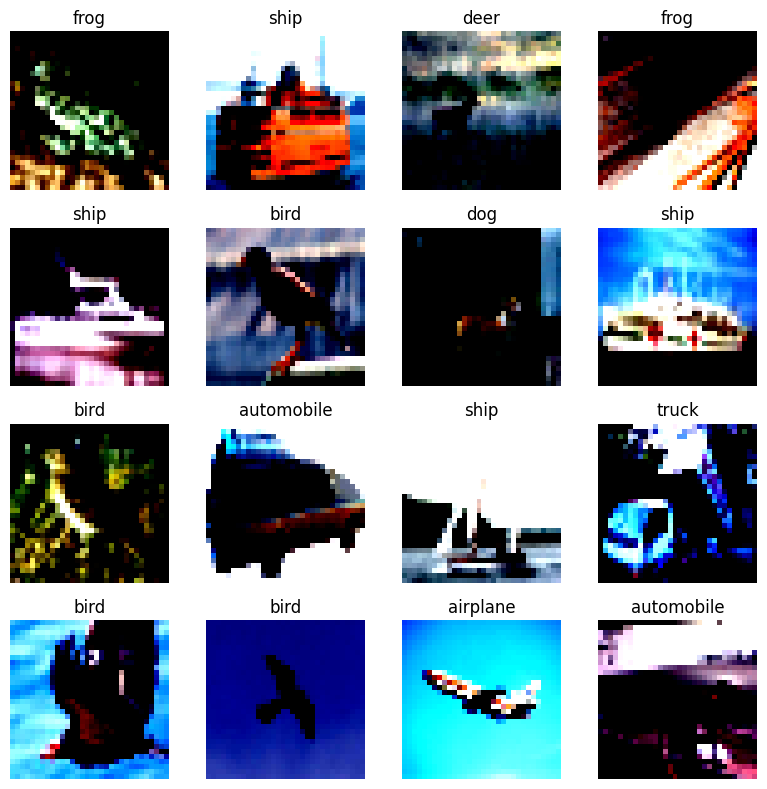

In [6]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img = images[i].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.axis('off')
    plt.title(classes[labels[i]])
plt.tight_layout()
plt.show()

# ================================================================
### 5. Define Feed-Forward Neural Network (DNN)
# =======================================================

BatchNorm tries to stabilize activations, while Dropout randomly kills them. Result: training becomes noisy and fails to converge.

In [8]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()

        # Layer 1
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()
        #self.dropout1 = nn.Dropout(0.5)


        # Layer 2
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu2 = nn.ReLU()
        #self.dropout2 = nn.Dropout(0.5)

        # Layer 3
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()
       # self.dropout3 = nn.Dropout(0.5)

        # Layer 4 (output)
        self.fc4 = nn.Linear(128, num_classes)


    def forward(self, x):
        x = self.flatten(x)

        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.relu2(self.bn2(self.fc2(x)))
        x = self.relu3(self.bn3(self.fc3(x)))
        x = self.fc4(x)  # final logits

        return x


# Example usage
input_size = IMG_SIZE * IMG_SIZE * 3
num_classes = len(classes)

model = FeedForwardNN(input_size=input_size, num_classes=num_classes).to(device)
print(model)


FeedForwardNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


# ================================================================
### 6. Loss Function and Optimizer
# ================================================================


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)



# ================================================================
### 7. Training Loop
# ================================================================


In [12]:
num_epochs = 20
train_losses, val_losses, train_acc, val_acc = [], [], [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, train_correct, train_total = 0.0, 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * y_batch.size(0)
        _, predicted = outputs.max(1)
        train_total += y_batch.size(0)
        train_correct += predicted.eq(y_batch).sum().item()

    epoch_loss = running_loss / train_total
    epoch_acc = 100.0 * train_correct / train_total
    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_running_loss += loss.item() * y_batch.size(0)
            _, predicted = outputs.max(1)
            val_total += y_batch.size(0)
            val_correct += predicted.eq(y_batch).sum().item()

    val_losses.append(val_running_loss / val_total)
    val_acc.append(100.0 * val_correct / val_total)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc[-1]:.2f}%")


Epoch [1/20] Train Loss: 1.7803, Train Acc: 36.38% Val Loss: 1.6636, Val Acc: 39.83%
Epoch [2/20] Train Loss: 1.5870, Train Acc: 43.02% Val Loss: 1.5882, Val Acc: 42.90%
Epoch [3/20] Train Loss: 1.4972, Train Acc: 46.27% Val Loss: 1.5581, Val Acc: 43.74%
Epoch [4/20] Train Loss: 1.4238, Train Acc: 49.19% Val Loss: 1.5524, Val Acc: 44.34%
Epoch [5/20] Train Loss: 1.3614, Train Acc: 51.42% Val Loss: 1.5303, Val Acc: 45.05%
Epoch [6/20] Train Loss: 1.2984, Train Acc: 53.79% Val Loss: 1.5393, Val Acc: 45.05%
Epoch [7/20] Train Loss: 1.2395, Train Acc: 56.04% Val Loss: 1.5456, Val Acc: 45.20%
Epoch [8/20] Train Loss: 1.1803, Train Acc: 58.25% Val Loss: 1.5473, Val Acc: 45.53%
Epoch [9/20] Train Loss: 1.1145, Train Acc: 60.80% Val Loss: 1.5751, Val Acc: 45.54%
Epoch [10/20] Train Loss: 1.0572, Train Acc: 62.92% Val Loss: 1.6032, Val Acc: 45.15%
Epoch [11/20] Train Loss: 0.9972, Train Acc: 65.27% Val Loss: 1.6409, Val Acc: 44.83%
Epoch [12/20] Train Loss: 0.9451, Train Acc: 67.13% Val Loss: 1

# ================================================================
### 8. Plot Training and Validation Curves
# ================================================================


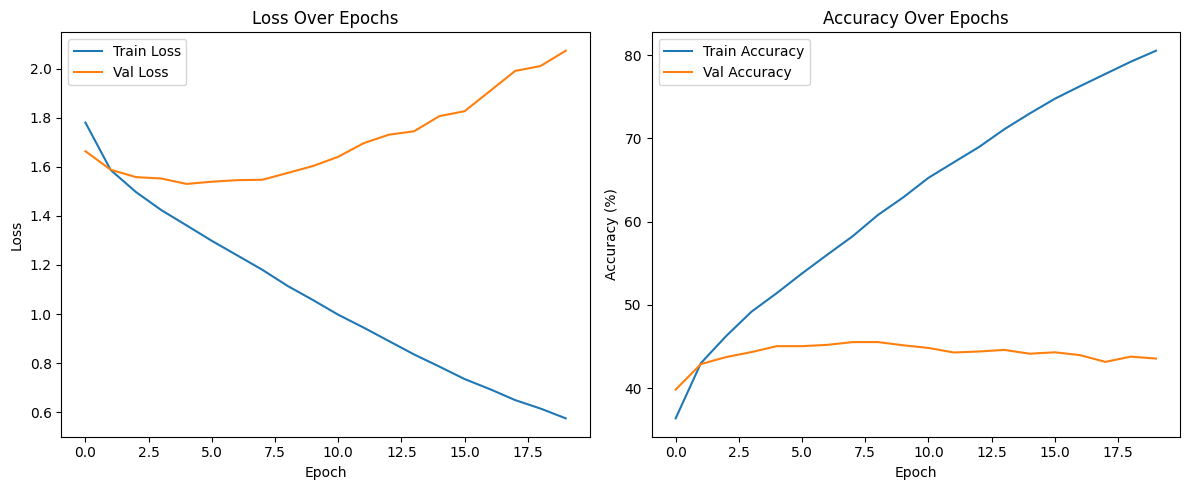

In [13]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


# ================================================================
### 9. Evaluate on Test Set
# ================================================================


              precision    recall  f1-score   support

    airplane       0.53      0.63      0.57      9000
  automobile       0.52      0.48      0.50      9000
        bird       0.36      0.36      0.36      9000
         cat       0.30      0.32      0.31      9000
        deer       0.35      0.32      0.33      9000
         dog       0.31      0.30      0.30      9000
        frog       0.53      0.55      0.54      9000
       horse       0.51      0.49      0.50      9000
        ship       0.49      0.49      0.49      9000
       truck       0.47      0.45      0.46      9000

    accuracy                           0.44     90000
   macro avg       0.44      0.44      0.44     90000
weighted avg       0.44      0.44      0.44     90000



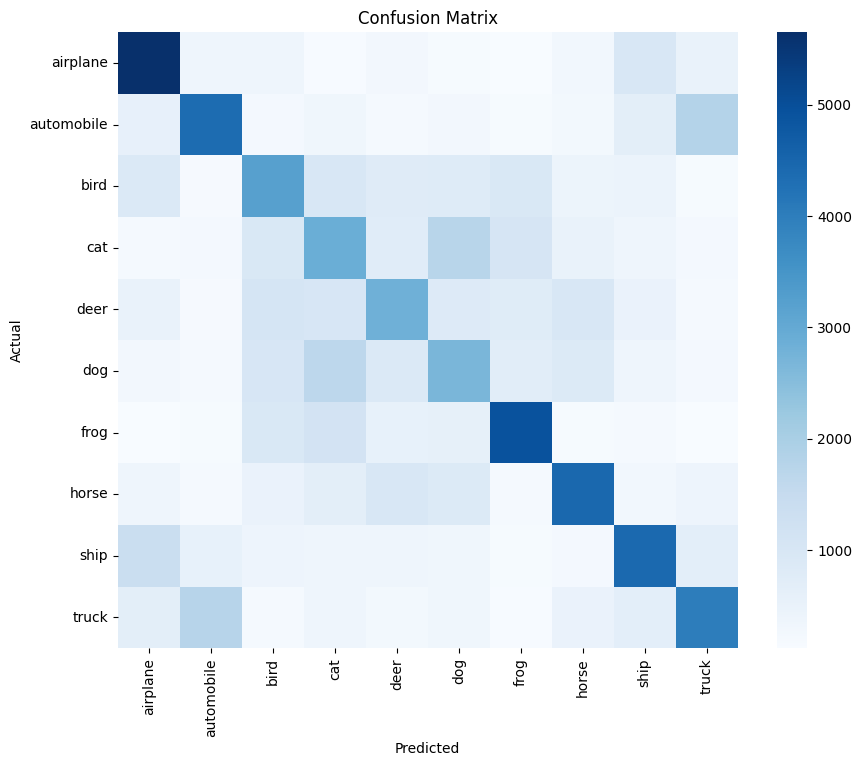

In [14]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


  Displaying some images, to visually appreciate model progreaa

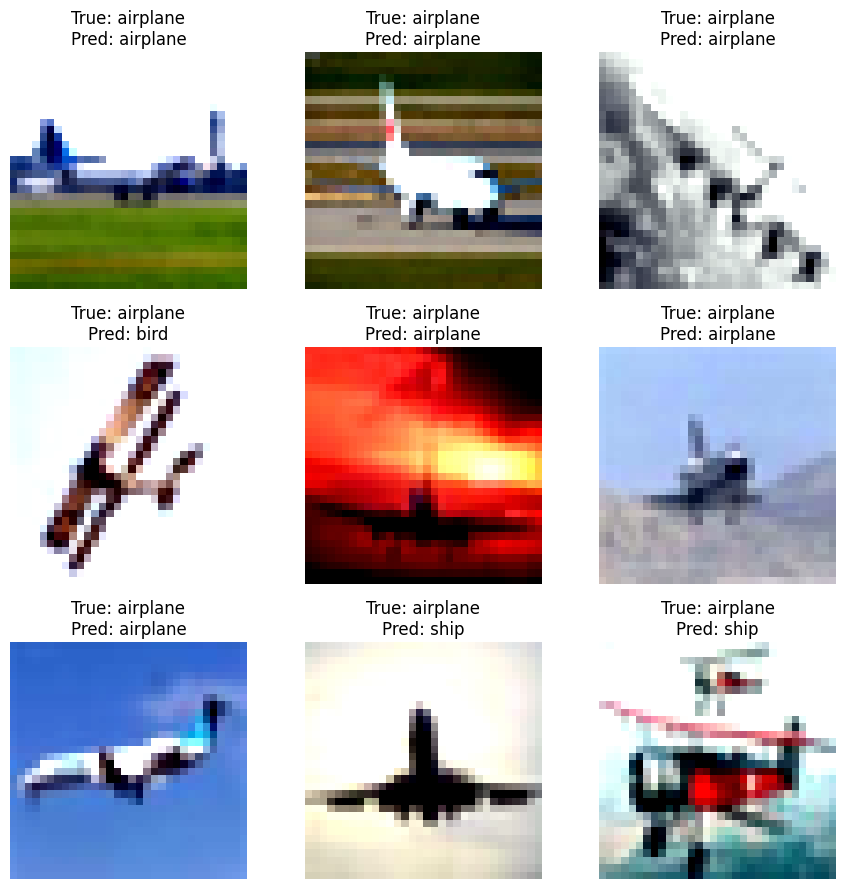

In [22]:
import random

# Get a batch from validation
data_iter = iter(val_loader)
images, labels = next(data_iter)

images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Show a few
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for i, ax in enumerate(axes.flat):
    # Pick an index
    idx = random.randint(0, len(images) - 1)
    img = images[idx].cpu().permute(1, 2, 0).numpy()  # CHW → HWC for matplotlib
    img = (img * 0.5 + 0.5).clip(0, 1)  # unnormalize if you normalized [-1,1]

    true_label = classes[labels[idx].item()]
    pred_label = classes[preds[idx].item()]

    ax.imshow(img)
    ax.set_title(f"True: {true_label}\nPred: {pred_label}")
    ax.axis("off")

plt.tight_layout()
plt.show()


# ================================================================
### 10. Save and Load Model
# ================================================================


In [23]:
torch.save(model.state_dict(), "feedforward_model.pth")
print("Model saved.")

model = FeedForwardNN(input_size=input_size, num_classes=num_classes).to(device)
model.load_state_dict(torch.load("feedforward_model.pth"))
model.eval()
print("Model reloaded and ready.")

Model saved.
Model reloaded and ready.
